In [1]:
import numpy as np
import pandas as pd
import multiprocessing as mp
from inspect import signature
from matplotlib import pyplot as plt
from dacbench.logger import Logger, log2dataframe, load_logs
import seaborn as sns
import glob
from plotting import _plot_performance_over_time, plot_performance_over_time, plot_final_performance_comparison, plot_improvement_probability, plot_configuration_footprint, plot_hp_importance, plot_deepcave
#from plotting import plot_performance_over_time, plot_final_performance_comparison, plot_improvement_probability, plot_configuration_footprint, plot_hp_importance, plot_deepcave

/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/dacbench/envs/__init__.py:35: UserWarning: CMA-ES Benchmark not installed. If you want to use this benchmark, please follow the installation guide.
  warnings.warn(  # noqa: B028
/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/dacbench/benchmarks/__init__.py:26: UserWarning: CMA-ES Benchmark not installed. If you want to use this benchmark, please follow the installation guide.
  warnings.warn(  # noqa: B028


DACBench Gym registration failed - make sure you have all dependencies installed and their instance sets in the right path!


In [2]:
import json
import glob
import pandas as pd
from typing import List
import seaborn as sns

def extract_metric_all_seeds(trainer_state_paths: List[str],
                             seeds: List[int],
                             metric_key: str,
                             method: str,
                             max_step: int = None) -> pd.DataFrame:
    """
    Given multiple trainer_state.json file paths (one per seed), extract a chosen metric
    (e.g., 'train_perplexity' or 'eval_perplexity') from each file and combine them into
    a single DataFrame with columns: ['step', 'seed', 'value', 'method'].
    
    :param trainer_state_paths: List of paths to trainer_state.json files.
    :param seeds: List of integer seeds corresponding to each file path.
    :param metric_key: The key for the metric to extract (e.g., 'train_perplexity').
    :param method: The method/optimizer name (e.g., 'COCOB', 'DAdaptAdam', etc.).
    :param max_step: Optional maximum step value. Only log entries with 'step' <= max_step will be kept.
    :return: A pandas DataFrame with columns ['step', 'seed', 'value', 'method'].
    """
    if len(trainer_state_paths) != len(seeds):
        raise ValueError("The number of trainer_state paths must match the number of seeds.")

    df_list = []
    for path, seed in zip(trainer_state_paths, seeds):
        with open(path, "r") as f:
            trainer_state = json.load(f)

        data_for_this_seed = []
        for log_entry in trainer_state.get("log_history", []):
            # Only include entries that have both the metric and a 'step'
            if metric_key in log_entry and "step" in log_entry:
                # If max_step is provided, skip entries beyond that step
                if max_step is not None and log_entry["step"] > max_step:
                    continue
                data_for_this_seed.append({
                    "step": log_entry["step"],
                    "seed": seed,
                    "value": log_entry[metric_key],
                    "method": method
                })

        if data_for_this_seed:
            df_list.append(pd.DataFrame(data_for_this_seed))

    if df_list:
        return pd.concat(df_list, ignore_index=True)
    else:
        # Return an empty DataFrame with the expected columns if no data is found.
        return pd.DataFrame(columns=["step", "seed", "value", "method"])

def extract_metric_from_parent_dir(parent_dir: str,
                                   metric_key: str,
                                   method: str,
                                   max_step: int = None) -> pd.DataFrame:
    """
    Searches for all trainer_state.json files within the subdirectories of the given parent directory,
    using a glob pattern that matches the structure:
    
        parent_dir/*/results/*/trainer_state.json
    
    Seeds are automatically assigned based on the sorted order of the files.
    
    :param parent_dir: The parent directory for the method (e.g. "./COCOB_roberta_bookwiki")
    :param metric_key: The metric key to extract (e.g., "train_perplexity" or "eval_perplexity")
    :param method: The method/optimizer name (e.g., "COCOB", "DAdaptAdam", etc.)
    :param max_step: Optional maximum step value. Only log entries with 'step' <= max_step will be kept.
    :return: A pandas DataFrame with columns ['step', 'seed', 'value', 'method'].
    """
    # Create the glob pattern to find trainer_state.json files
    pattern = f"{parent_dir}/*/results/*/trainer_state.json"
    trainer_state_paths = sorted(glob.glob(pattern))
    
    # Automatically assign seed values based on the sorted order
    seeds = list(range(1, len(trainer_state_paths) + 1))
    
    return extract_metric_all_seeds(trainer_state_paths, seeds, metric_key, method, max_step=max_step)

def downsample_data(df, bin_size=50):
    """
    Downsamples the DataFrame by binning steps.
    
    :param df: Input DataFrame with a 'step' column.
    :param bin_size: The bin size to aggregate over.
    :return: Downsampled DataFrame with binned steps.
    """
    # Create a new column for the bin index based on the step
    df['step'] = (df['step'] // bin_size) * bin_size
    # Group by method, seed, and binned step, then compute the mean value
    grouped = df.groupby(['method', 'seed', 'step'])['value'].mean().reset_index()
    return grouped

def get_final_labels_and_stats(data, epoch_col="epoch", value_col="value", group_col="method",
                               label_format="{label} ({mean:.3f} SE {sem:.3f})"):
    """
    Computes final aggregated stats and creates new legend labels, preserving the original order.

    Parameters:
    -----------
    data : pd.DataFrame
        DataFrame containing the data with columns for epoch, value, and group identifier.
    epoch_col : str, default "epoch"
        Column name representing the epoch.
    value_col : str, default "value"
        Column name for the metric values.
    group_col : str, default "method"
        Column name used to group the data.
    label_format : str, default "{label}: {mean:.3f} ± {sem:.3f}"
        A format string used to create new legend labels, where {label} is the group,
        {mean} is the computed mean, and {sem} is the standard error.

    Returns:
    --------
    new_labels : list of str
        A list of updated legend labels with the final aggregated values in the original order.
    final_stats : pd.DataFrame
        A DataFrame indexed by the group column containing the mean and standard error,
        reindexed to preserve the original order of appearance.
    """
    # Determine the final epoch
    final_epoch = data[epoch_col].max()

    # Filter data to only include the final epoch
    final_data = data[data[epoch_col] == final_epoch]

    # Compute aggregated statistics (mean and standard error) grouped by the given group column
    final_stats = final_data.groupby(group_col)[value_col].agg(["mean", "sem"])

    # Get the original order of methods as they first appear in the data
    original_order = data[group_col].drop_duplicates().tolist()

    # Reindex final_stats to follow the original order (dropping any methods that might be missing)
    final_stats = final_stats.reindex(original_order)

    # Create new labels in the preserved order
    new_labels = []
    for label in original_order:
        if label in final_stats.index and pd.notnull(final_stats.loc[label, "mean"]):
            new_label = label_format.format(label=label,
                                            mean=final_stats.loc[label, "mean"],
                                            sem=final_stats.loc[label, "sem"])
        else:
            new_label = label
        new_labels.append(new_label)
    
    return new_labels

# Example of setting up Seaborn plotting options:
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_style('whitegrid')
palette = sns.color_palette("colorblind")
palette = sns.color_palette([palette[0], palette[4], palette[2], palette[5], palette[8], palette[6], palette[9], palette[7]])
sns.set_palette(palette)
sns.set_context("notebook", font_scale=1.15)

/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/seaborn/_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(
/tmp/ipykernel_353896/1941442974.py:80: UserWarning: Tight layout not appli

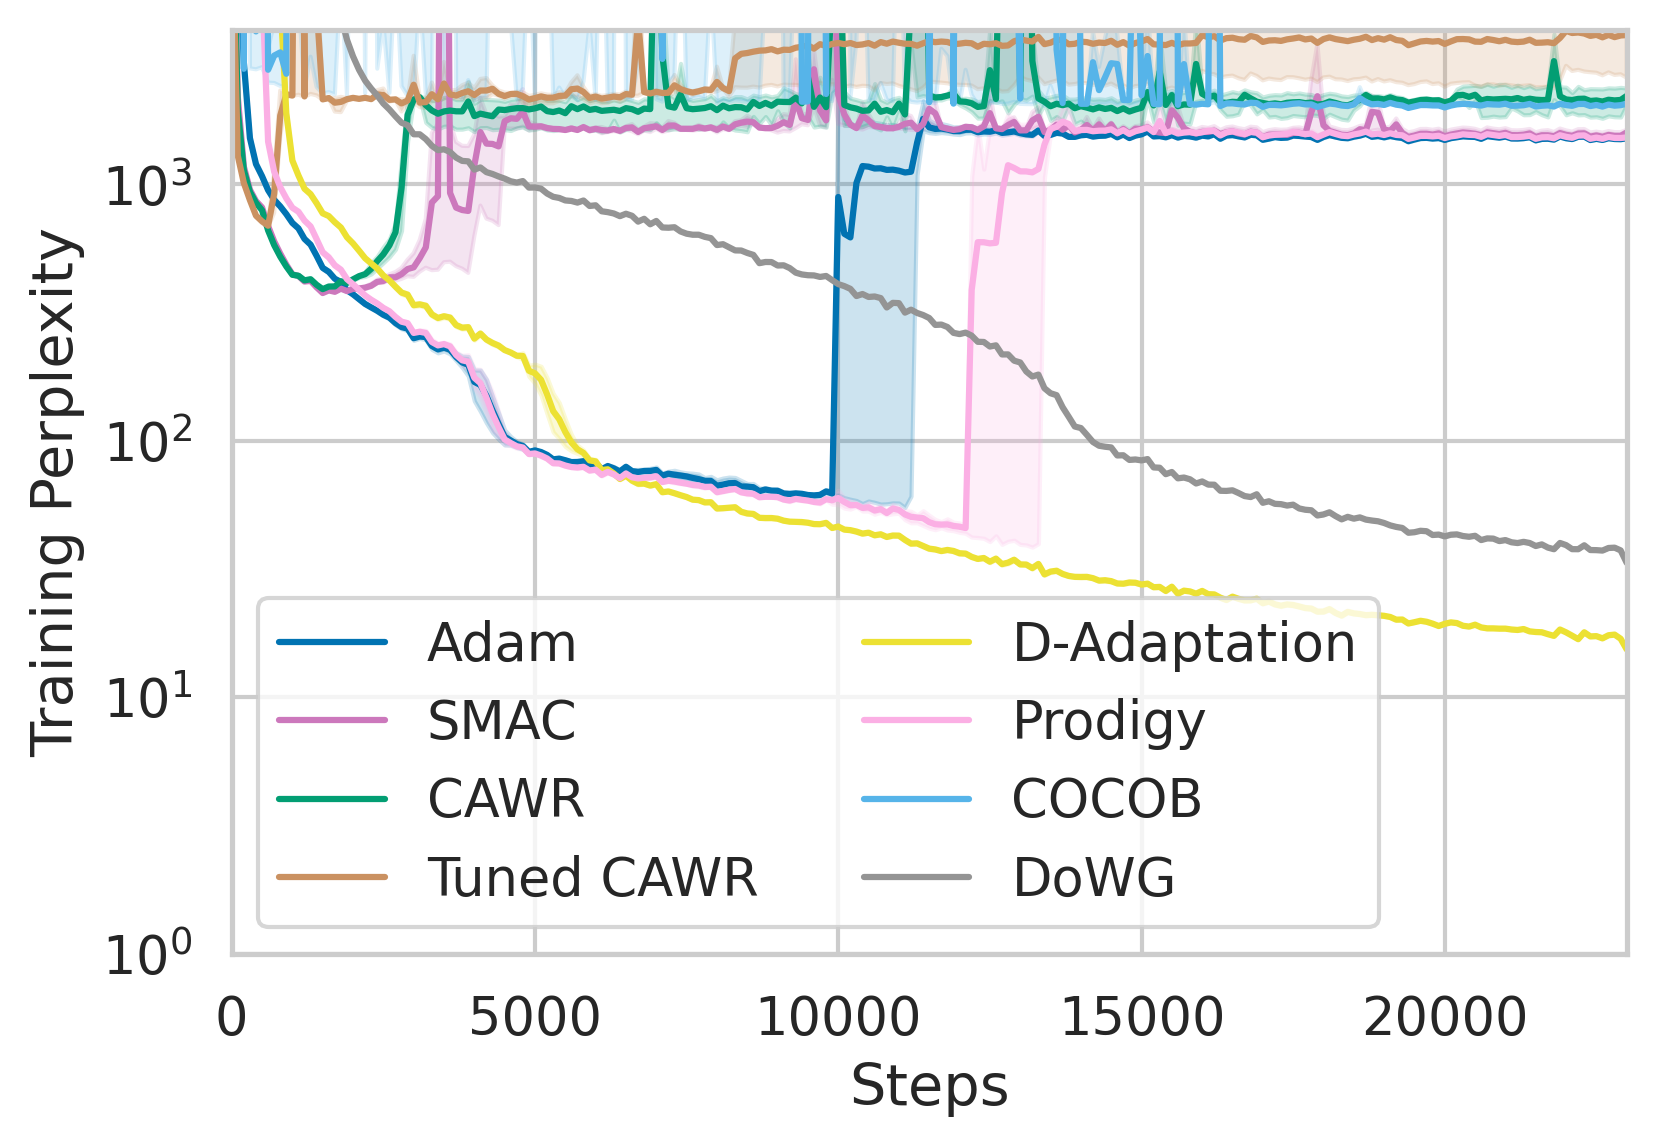

In [3]:
max_steps=23000
metric="train_perplexity"

adamfixed_tp = extract_metric_from_parent_dir(
    parent_dir="../results_cluster/results/Adam_fixed_roberta_bookwiki",
    metric_key=metric,
    method="Adam",
    max_step=max_steps
)

smacfixed_tp = extract_metric_from_parent_dir(
    parent_dir="../results_cluster/results/tuned_smacfixed_roberta_bookwiki",
    metric_key=metric,
    method="SMAC",
    max_step=max_steps
)

cawr_tp = extract_metric_from_parent_dir(
    parent_dir="../results_cluster/results/CAWR_roberta_bookwiki",
    metric_key=metric,
    method="CAWR",
    max_step=max_steps
)

tuned_cawr_tp = extract_metric_from_parent_dir(
    parent_dir="../results_cluster/results/tuned_CAWR_roberta_bookwiki",
    metric_key=metric,
    method="Tuned CAWR",
    max_step=max_steps
)

cocob_tp = extract_metric_from_parent_dir(
    parent_dir="../results_cluster/results/COCOB_roberta_bookwiki",
    metric_key=metric,
    method="COCOB",
    max_step=max_steps
)

dadaptation_tp = extract_metric_from_parent_dir(
    parent_dir="../results_cluster/results/DAdaptAdam_roberta_bookwiki",
    metric_key=metric,
    method="D-Adaptation",
    max_step=max_steps
)

dowg_tp = extract_metric_from_parent_dir(
    parent_dir="../results_cluster/results/DoWG_roberta_bookwiki",
    metric_key=metric,
    method="DoWG",
    max_step=max_steps
)

prodigy_tp = extract_metric_from_parent_dir(
    parent_dir="../results_cluster/results/ProdigyAdam_roberta_bookwiki",
    metric_key=metric,
    method="Prodigy",
    max_step=max_steps
)

# Combine all training DataFrames:
df_train_all = pd.concat([adamfixed_tp, smacfixed_tp, cawr_tp, tuned_cawr_tp, dadaptation_tp, prodigy_tp, cocob_tp, dowg_tp], ignore_index=True)
df_train_all = downsample_data(df_train_all, bin_size=100)
desired_order = ["Adam", "SMAC", "CAWR", "Tuned CAWR", "D-Adaptation", "Prodigy", "COCOB", "DoWG"]
df_train_all["method"] = pd.Categorical(df_train_all["method"], categories=desired_order, ordered=True)
df_train_all = df_train_all.sort_values("method")

fig = _plot_performance_over_time(
    df_train_all,
    x="step",
    y="value",
    hue="method",
    aggregation="mean",
    logx=False,
    logy=True,
    xlabel="Steps",
    ylabel="Training Perplexity",
    ylim=(1, 4000),  # Adjust as needed
    palette=palette,
)
plt.tight_layout()
fig.set_size_inches(6, 4, forward=True)
fig.gca().set_title("")
handles, labels = fig.gca().get_legend_handles_labels()
fig.gca().legend(handles, labels, loc="lower left", bbox_to_anchor=(0, 0),
          ncol=2, title=None, frameon=True)

     method  seed   step      value
0      Adam     1      0  10.126487
458    Adam     2  22700   9.373471
459    Adam     2  22800   9.359042
460    Adam     2  22900   9.376775
461    Adam     2  23000   9.377937
...     ...   ...    ...        ...
2689   DoWG     1  14800   4.372009
2688   DoWG     1  14700   4.444574
2687   DoWG     1  14600   4.436910
2685   DoWG     1  14400   4.479952
2656   DoWG     1  11500   5.694600

[5313 rows x 4 columns]


/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/seaborn/_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(
/tmp/ipykernel_353896/65240131.py:72: UserWarning: Tight layout not applied

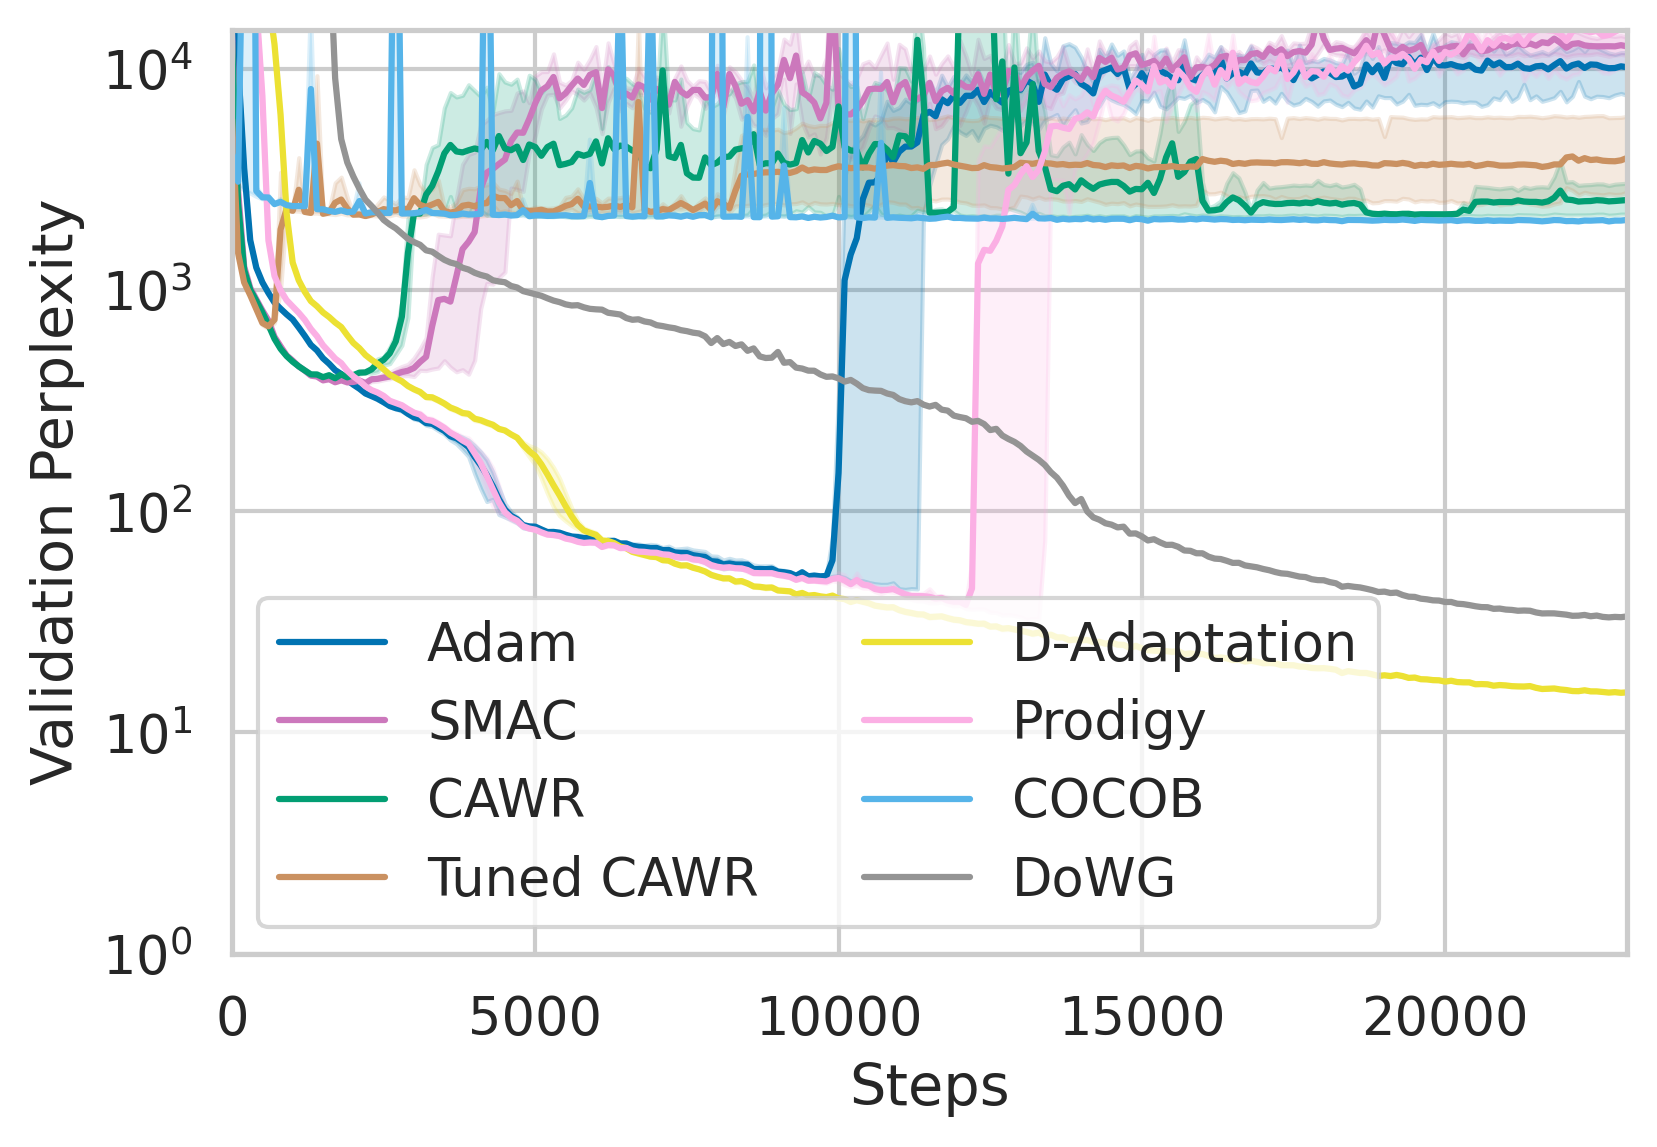

In [4]:
adamfixed_ep = extract_metric_from_parent_dir(
    parent_dir="../results_cluster/results/Adam_fixed_roberta_bookwiki",
    metric_key="eval_loss",
    method="Adam"
)

smacfixed_ep = extract_metric_from_parent_dir(
    parent_dir="../results_cluster/results/tuned_smacfixed_roberta_bookwiki",
    metric_key="eval_loss",
    method="SMAC"
)

cawr_ep = extract_metric_from_parent_dir(
    parent_dir="../results_cluster/results/CAWR_roberta_bookwiki",
    metric_key="eval_loss",
    method="CAWR",
)

tuned_cawr_ep = extract_metric_from_parent_dir(
    parent_dir="../results_cluster/results/tuned_CAWR_roberta_bookwiki",
    metric_key="eval_loss",
    method="Tuned CAWR",
)

cocob_ep = extract_metric_from_parent_dir(
    parent_dir="../results_cluster/results/COCOB_roberta_bookwiki",
    metric_key="eval_loss",
    method="COCOB"
)

dadaptation_ep = extract_metric_from_parent_dir(
    parent_dir="../results_cluster/results/DAdaptAdam_roberta_bookwiki",
    metric_key="eval_loss",
    method="D-Adaptation"
)

dowg_ep = extract_metric_from_parent_dir(
    parent_dir="../results_cluster/results/DoWG_roberta_bookwiki",
    metric_key="eval_loss",
    method="DoWG"
)

prodigy_ep = extract_metric_from_parent_dir(
    parent_dir="../results_cluster/results/ProdigyAdam_roberta_bookwiki",
    metric_key="eval_loss",
    method="Prodigy"
)


# Combine all training DataFrames:
df_eval_all = pd.concat([adamfixed_ep, smacfixed_ep, tuned_cawr_ep ,cawr_ep, dadaptation_ep, prodigy_ep, cocob_ep, dowg_ep], ignore_index=True)
df_eval_all = downsample_data(df_eval_all, bin_size=100)
df_eval_all["method"] = pd.Categorical(df_eval_all["method"], categories=desired_order, ordered=True)
df_eval_all = df_eval_all.sort_values("method")
print(df_eval_all)
df_eval_all['value'] = np.exp(df_eval_all['value'])

fig = _plot_performance_over_time(
    df_eval_all,
    x="step",
    y="value",
    hue="method",
    aggregation="mean",
    logx=False,
    logy=True,
    xlabel="Steps",
    ylabel="Validation Perplexity",
    ylim=(1, 15000),  # Adjust as needed
    palette=palette,
)

plt.tight_layout()
fig.set_size_inches(6, 4, forward=True)
fig.gca().set_title("")
handles, labels = fig.gca().get_legend_handles_labels()
fig.gca().legend(handles, labels, loc="lower left", bbox_to_anchor=(0, 0),
          ncol=2, title=None, frameon=True)


In [ ]:
test = extract_metric_from_parent_dir(
    parent_dir="../results_cluster/results/roberta_test",
    metric_key="learning_rate",
    method="CAWR",
)

print(test)

# Combine all training DataFrames:
df_eval_all = pd.concat([test], ignore_index=True)
df_eval_all["method"] = pd.Categorical(df_eval_all["method"], categories=desired_order, ordered=True)
print(df_eval_all)
_plot_performance_over_time(
    df_eval_all,
    x="step",
    y="value",
    hue="method",
    aggregation="mean",
    logx=False,
    xlabel="Steps",
    ylabel="Validation Perplexity",
    # ylim=(7, 8)  # Adjust as needed
)

          method  seed   step     value
0     Adam Fixed     1      0  0.000002
1     Adam Fixed     1     50  0.000007
2     Adam Fixed     1    100  0.000012
3     Adam Fixed     1    150  0.000017
4     Adam Fixed     1    200  0.000022
...          ...   ...    ...       ...
8293  Tuned CAWR     3  22800  0.014094
8294  Tuned CAWR     3  22850  0.014078
8295  Tuned CAWR     3  22900  0.014060
8296  Tuned CAWR     3  22950  0.014042
8297  Tuned CAWR     3  23000  0.014032

[8298 rows x 4 columns]


/home/micha/Studium/BA_new/BA-Parameter-Free-DAC/ba_parameter_free_dac/plotting/plotting.py:208: UserWarning: The palette list has more values (8) than needed (6), which may not be intended.
  ax = sns.lineplot(data=data, x=x, y=y, ax=ax, marker=marker, hue=hue, errorbar=errorbar, estimator=aggregation,palette=palette if palette is not None else sns.color_palette('colorblind', as_cmap = True))
/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/micha/anaconda3/envs/PFDAC/

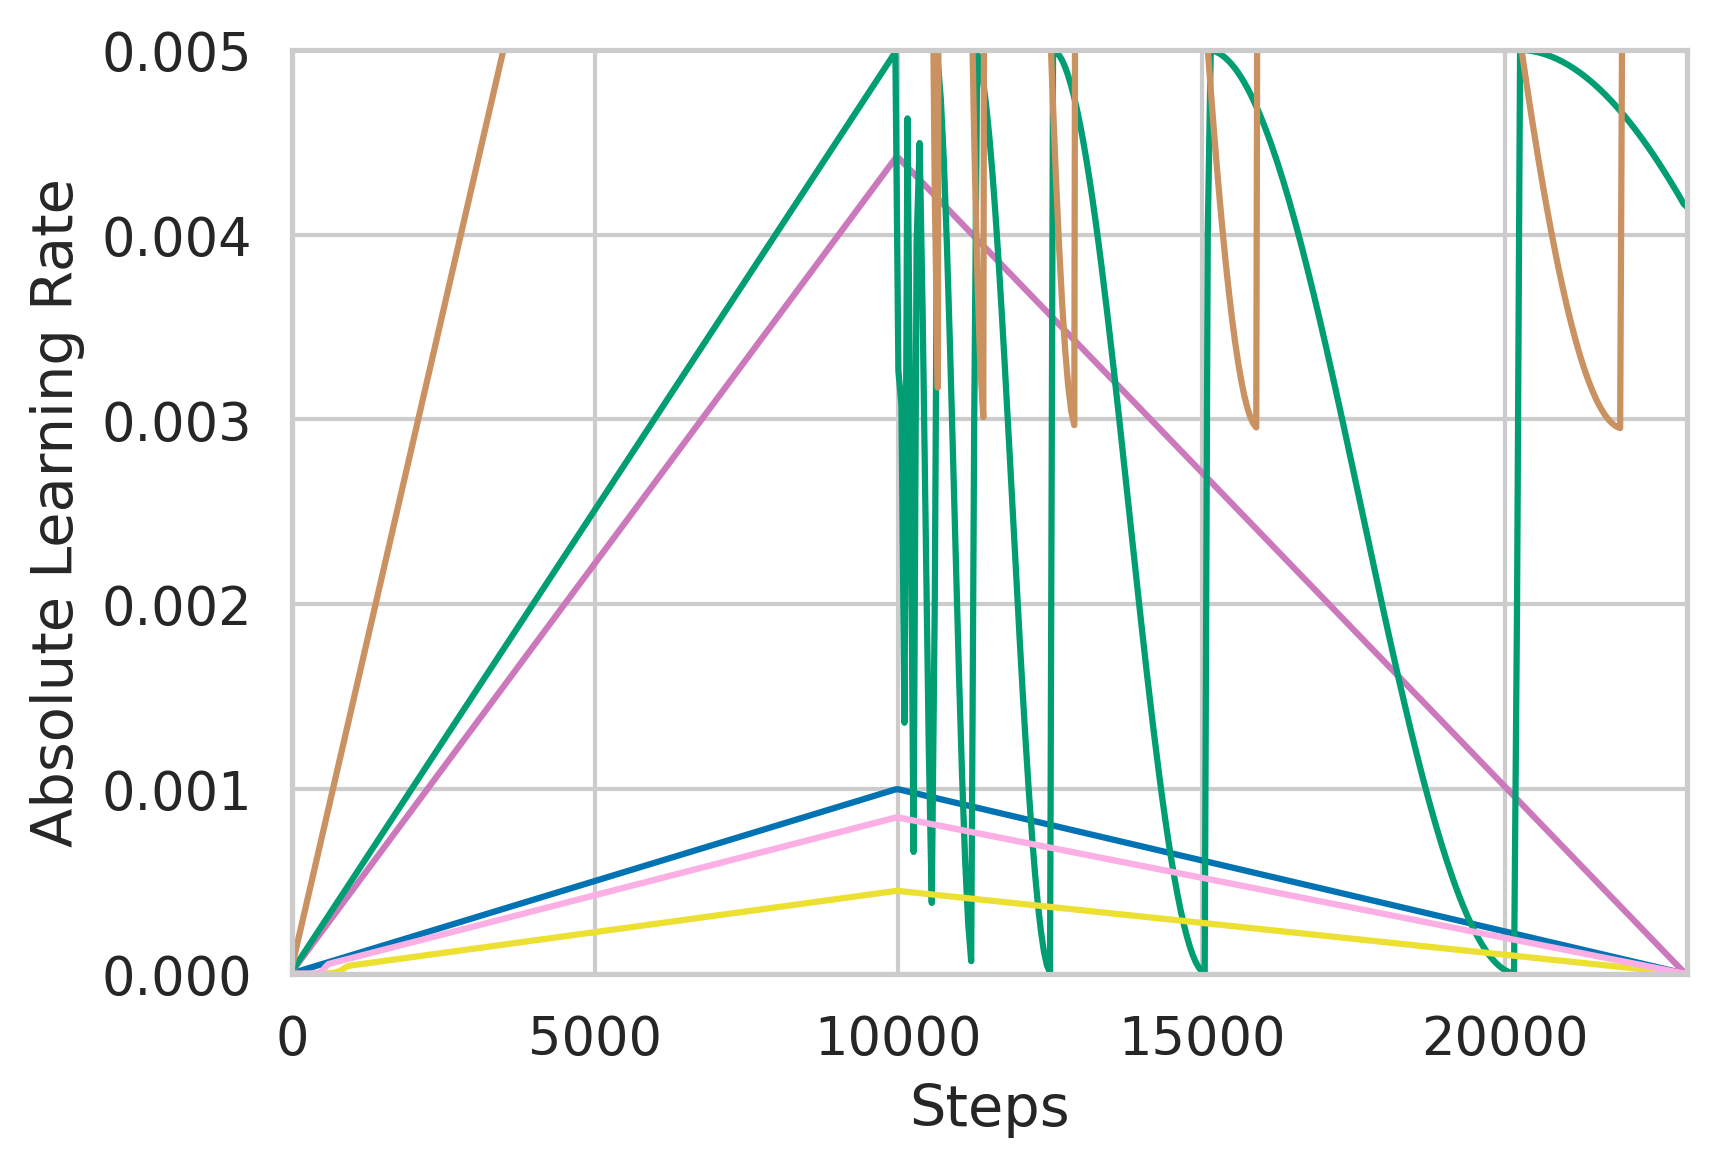

In [5]:
max_steps=23000
metric="learning_rate"

adamfixed_tp = extract_metric_from_parent_dir(
    parent_dir="../results_cluster/results/Adam_fixed_roberta_bookwiki",
    metric_key=metric,
    method="Adam Fixed",
    max_step=max_steps
)

smacfixed_tp = extract_metric_from_parent_dir(
    parent_dir="../results_cluster/results/tuned_smacfixed_roberta_bookwiki",
    metric_key=metric,
    method="SMAC Fixed",
    max_step=max_steps
)

cawr_tp = extract_metric_from_parent_dir(
    parent_dir="../results_cluster/results/CAWR_roberta_bookwiki",
    metric_key=metric,
    method="CAWR",
    max_step=max_steps
)

tuned_cawr_tp = extract_metric_from_parent_dir(
    parent_dir="../results_cluster/results/tuned_CAWR_roberta_bookwiki",
    metric_key=metric,
    method="Tuned CAWR",
    max_step=max_steps
)

dadaptation_tp = extract_metric_from_parent_dir(
    parent_dir="../results_cluster/results/DAdaptAdam_roberta_bookwiki",
    metric_key="dlr",
    method="D-Adaptation",
    max_step=max_steps
)


prodigy_tp = extract_metric_from_parent_dir(
    parent_dir="../results_cluster/results/ProdigyAdam_roberta_bookwiki",
    metric_key="dlr",
    method="Prodigy",
    max_step=max_steps
)

# Combine all training DataFrames:
df_train_all = pd.concat([adamfixed_tp, smacfixed_tp, cawr_tp, tuned_cawr_tp, dadaptation_tp, prodigy_tp], ignore_index=True)
df_train_all = downsample_data(df_train_all, bin_size=50)
print(df_train_all)
desired_order = ["Adam Fixed", "SMAC Fixed", "CAWR", "Tuned CAWR", "D-Adaptation", "Prodigy"]
df_train_all["method"] = pd.Categorical(df_train_all["method"], categories=desired_order, ordered=True)
df_train_all = df_train_all.sort_values("method")
fig1 = _plot_performance_over_time(
    df_train_all,
    x="step",
    y="value",
    hue="method",
    aggregation="mean",
    logx=False,
    # logy=True,
    xlabel="Steps",
    ylabel="Absolute Learning Rate",
    ylim=(0, 0.005),  # Adjust as needed
    palette=palette
)

plt.tight_layout()
fig1.set_size_inches(6, 4, forward=True)
fig1.gca().set_title("")
fig1.gca().get_legend().remove()

# fig1.gca().legend(handles, labels, loc="lower left", bbox_to_anchor=(1, 0.25),
#           ncol=1, title=None, frameon=True)

        step  seed         value method
0          1     1  57468.925781   CAWR
1          2     1  58542.015625   CAWR
2          3     1  57687.746094   CAWR
3          4     1  55642.335938   CAWR
4          5     1  54584.230469   CAWR
...      ...   ...           ...    ...
68995  22996     3   1650.609375   CAWR
68996  22997     3   2150.595459   CAWR
68997  22998     3   1789.157349   CAWR
68998  22999     3   1812.386841   CAWR
68999  23000     3   2041.010010   CAWR

[69000 rows x 4 columns]


/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/seaborn/_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(


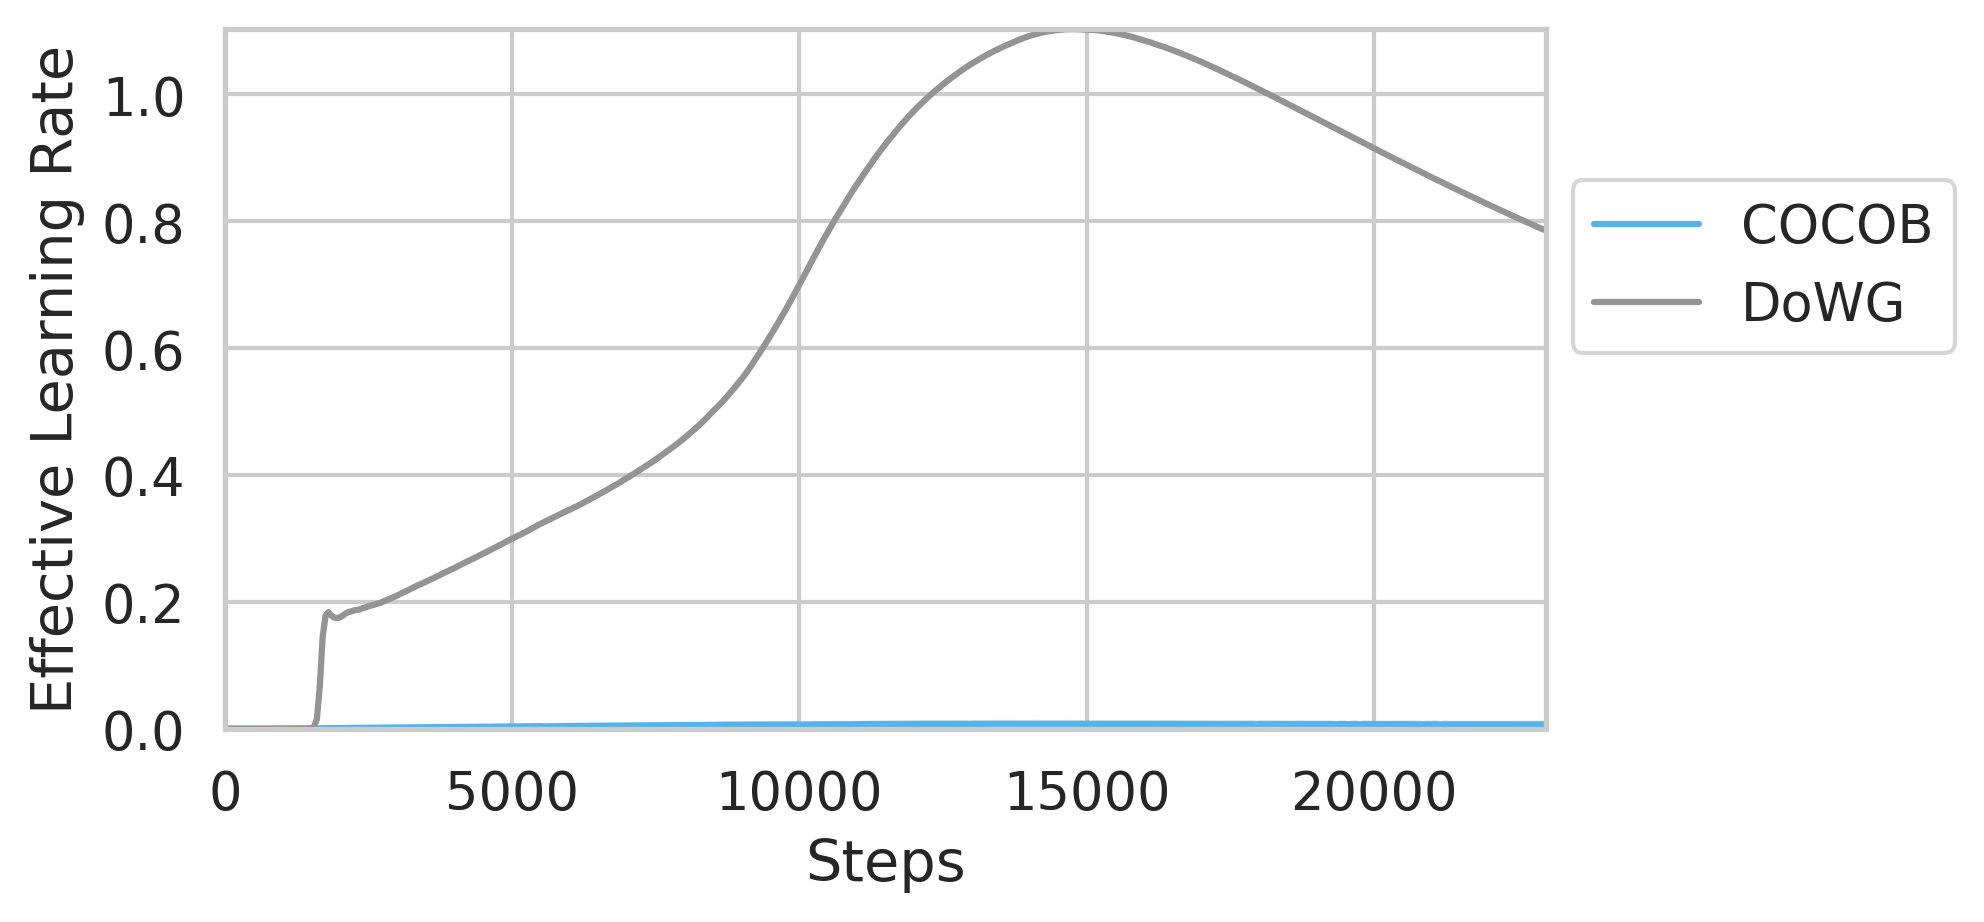

In [15]:
max_steps=23000
metric="learning_rate"

cocob_tp = extract_metric_from_parent_dir(
    parent_dir="../results_cluster/results/COCOB_roberta_bookwiki",
    metric_key="effective_lr",
    method="COCOB",
    max_step=max_steps
)

dowg_tp = extract_metric_from_parent_dir(
    parent_dir="../results_cluster/results/DoWG_roberta_bookwiki",
    metric_key="effective_lr",
    method="DoWG",
    max_step=max_steps
)


# Combine all training DataFrames:
df_train_all = pd.concat([cocob_tp, dowg_tp], ignore_index=True)
df_train_all = downsample_data(df_train_all, bin_size=50)
print(cawr_tp)
desired_order = ["COCOB", "DoWG"]
df_train_all["method"] = pd.Categorical(df_train_all["method"], categories=desired_order, ordered=True)
fig2 = _plot_performance_over_time(
    df_train_all,
    x="step",
    y="value",
    hue="method",
    aggregation="mean",
    logx=False,
    # logy=True,
    xlabel="Steps",
    ylabel="Effective Learning Rate",
    palette=sns.color_palette([palette[6], palette[7]])
    # ylim=(0, 0.005)  # Adjust as needed
)

plt.tight_layout()
fig2.set_size_inches(6, 4, forward=True)
fig2.gca().set_title("")
handles, labels = fig2.gca().get_legend_handles_labels()
fig2.gca().legend(handles, labels, loc="lower left", bbox_to_anchor=(1, 0.5),
          ncol=1, title=None, frameon=True)

/tmp/ipykernel_284680/671147975.py:29: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig_legend.tight_layout()


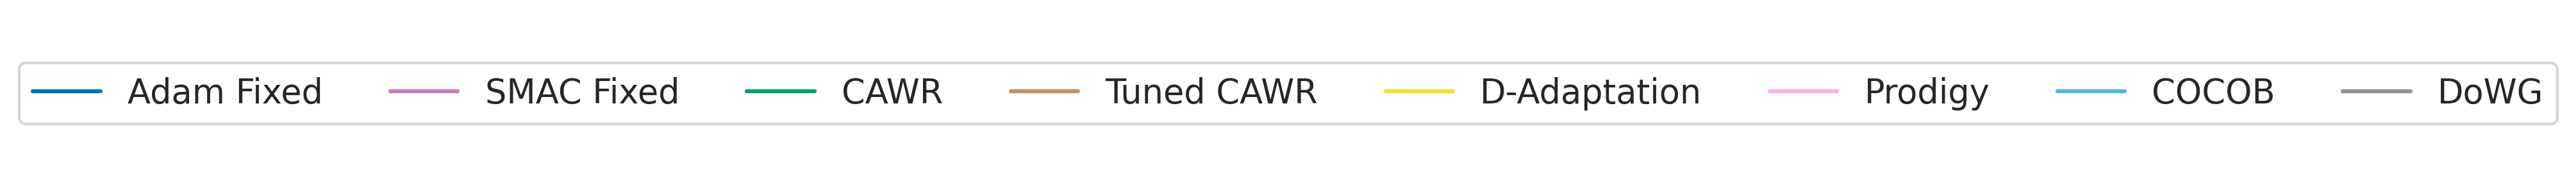

/tmp/ipykernel_284680/671147975.py:40: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig1.tight_layout(rect=[0, 0.1, 1, 1])


In [16]:
ax1 = fig1.gca()
ax2 = fig2.gca()

# Extract handles and labels from both figures.
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Merge them into a unified list, avoiding duplicates.
combined_handles = []
combined_labels = []

for h, l in zip(handles1, labels1):
    if l not in combined_labels:
        combined_labels.append(l)
        combined_handles.append(h)

for h, l in zip(handles2, labels2):
    if l not in combined_labels:
        combined_labels.append(l)
        combined_handles.append(h)

# Option 1: Create a new figure that displays just the unified legend.
fig_legend = plt.figure(figsize=(6, 1))
legend_ax = fig_legend.add_subplot(111)
legend_ax.axis("off")  # Hide the axes

legend = legend_ax.legend(combined_handles, combined_labels, loc="center",
                          ncol=len(combined_labels), frameon=True)
fig_legend.tight_layout()
plt.show()

# Option 2: Alternatively, if you want to add the unified legend to one of the existing figures,
# you could remove its local legend and then add the global one.
# For example, remove the legend from fig1 and add the unified legend there:
if ax1.get_legend() is not None:
    ax1.get_legend().remove()

ax1.legend(combined_handles, combined_labels, loc="upper center",
           bbox_to_anchor=(0.5, -0.05), ncol=len(combined_labels), frameon=True)
fig1.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()

In [10]:
methods = ["Adam_fixed", "tuned_smacfixed", "CAWR", "tuned_CAWR", "DAdaptAdam", "ProdigyAdam", "COCOB", "DoWG"]
datasets = ["roberta_bookwiki", ]
#"cifar10", "cifar100"

def transform(df, dataset):
    df['value'] = df.groupby(['method', 'seed'])['value'] \
                        .transform(lambda x: x.ewm(alpha=0.3, adjust=False).mean())
    df['value'] = np.exp(df['value'])
    df = df.groupby(["method", "step"], as_index=False)["value"].mean()
    df = df.loc[
        df.groupby(["method"])["step"].idxmax()
    ].reset_index(drop=True)
    df['dataset'] = dataset

    return df

df = pd.concat([transform(extract_metric_from_parent_dir('../results_cluster/results/' + method + '_' + dataset, metric_key='eval_loss',method=method), dataset) for method in methods for dataset in datasets], ignore_index=True)
print(df)
print("---")
# At this point, for each dataset-method we have the final validation accuracy in df["value"].
# Higher accuracy is better.

# --- Compute Marginal Contribution via Shapley Values ---

def calculate_marginal_contributions(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate marginal contribution per method for each dataset.

    Args:
    df (pd.DataFrame): The input DataFrame containing columns:
                       ['dataset', 'method', 'group', 'epoch', 'value']

    Returns:
    pd.DataFrame: A DataFrame showing marginal contributions for each method per dataset.
    """
    results = []

    # Get unique datasets and methods
    datasets = df['dataset'].unique()
    methods = df['method'].unique()
    
    for dataset in datasets:
        # Filter the DataFrame for the current dataset
        df_dataset = df[df['dataset'] == dataset]

        # Calculate the performance with all methods (Baseline)
        baseline_performance = df_dataset['value'].mean()

        for method in methods:
            # Filter out the current method to calculate "without" performance
            df_without_method = df_dataset[df_dataset['method'] != method]

            # Calculate the best performance without the current method
            if not df_without_method.empty:
                performance_without = df_without_method['value'].mean()
            else:
                performance_without = 0  # If no methods are left

            # Calculate the marginal contribution
            marginal_contribution = baseline_performance - performance_without

            # Store the results
            results.append({
                'dataset': dataset,
                'method': method,
                'baseline_performance': baseline_performance,
                'performance_without': performance_without,
                'marginal_contribution': marginal_contribution
            })

    # Convert the results to a DataFrame
    result_df = pd.DataFrame(results)
    
    return result_df

print(df)
mcs = calculate_marginal_contributions(df)
# mcs = mcs.groupby(["method"], as_index=False)["marginal_contribution"].mean()
print(mcs)

            method   step         value           dataset
0       Adam_fixed  23000  10180.704903  roberta_bookwiki
1  tuned_smacfixed  23000  12682.253731  roberta_bookwiki
2             CAWR  23000   2536.907328  roberta_bookwiki
3       tuned_CAWR  23000   3870.378920  roberta_bookwiki
4       DAdaptAdam  23000     15.176503  roberta_bookwiki
5      ProdigyAdam  23000  14908.138183  roberta_bookwiki
6            COCOB  23000   2061.675383  roberta_bookwiki
7             DoWG  23000     33.316968  roberta_bookwiki
---
            method   step         value           dataset
0       Adam_fixed  23000  10180.704903  roberta_bookwiki
1  tuned_smacfixed  23000  12682.253731  roberta_bookwiki
2             CAWR  23000   2536.907328  roberta_bookwiki
3       tuned_CAWR  23000   3870.378920  roberta_bookwiki
4       DAdaptAdam  23000     15.176503  roberta_bookwiki
5      ProdigyAdam  23000  14908.138183  roberta_bookwiki
6            COCOB  23000   2061.675383  roberta_bookwiki
7         

In [13]:
max_steps=23000

dadapt_dlr = extract_metric_from_parent_dir(
    parent_dir="../results_cluster/results/DAdaptAdam_roberta_bookwiki",
    metric_key="dlr",
    method="D-Adaptation",
    max_step=max_steps
)

prodigy_dlr = extract_metric_from_parent_dir(
    parent_dir="../results_cluster/results/ProdigyAdam_roberta_bookwiki",
    metric_key="effective_lr",
    method="Prodigy",
    max_step=max_steps
)



# Combine all training DataFrames:
df_train_all = pd.concat([dadapt_dlr, prodigy_dlr], ignore_index=True)
df_train_all = downsample_data(df_train_all, bin_size=50)

df_train_all = df_train_all.groupby(["method", "step"], as_index=False)["value"].mean()

# 2. Select the final epoch for each dataset-method-group combination
df_train_all = df_train_all.loc[
    df_train_all.groupby(["method"])["step"].idxmax()
].reset_index(drop=True)

print(df_train_all)

         method   step         value
0  D-Adaptation  23000  3.453551e-08
1       Prodigy  23000  2.809611e-04
